# Module 06: Newton's Method & Perceptron

**CS229 Aligned Curriculum** | *Gold Standard Edition*

## 0. What Are We Building?

### Newton's Method for Optimization - The Fast Track

Alright, let's talk about speed. You know gradient descent? It works, but it's like walking down a hill step by step. Newton's Method is more like hopping in a helicopter, calculating the exact coordinates of the valley floor, and landing there directly.

**Newton's Method** is a second-order optimization algorithm that uses curvature information (the Hessian matrix) to converge way faster than gradient descent. While gradient descent takes baby steps using only the slope, Newton's Method uses both slope and curvature to make smart jumps straight toward the minimum.

**Key Concepts:**
1. **Gradient Descent Update:** $\theta := \theta - \alpha \nabla J(\theta)$ (follow the slope downhill)
2. **Newton's Method Update:** $\theta := \theta - H^{-1} \nabla J(\theta)$ (use curvature to jump directly to the minimum)

See the difference? Gradient descent needs a learning rate $\alpha$ and takes many small steps. Newton's Method computes the optimal step size automatically using the Hessian matrix $H$.

---

### When to Use Newton's Method vs Gradient Descent?

| Scenario | Use Newton's Method | Use Gradient Descent |
|----------|---------|----------------|
| **Small number of features** | Yes (Hessian is n×n, manageable for n < 1000) | Not ideal (slower convergence) |
| **Need fast convergence** | Yes (Quadratic convergence - 5-10 iterations typical) | No (Linear convergence - hundreds of iterations) |
| **High dimensional problems** | No (Hessian inversion is $O(n^3)$ - too expensive!) | Yes (only needs gradient, $O(n)$ per step) |
| **Logistic regression with few features** | Perfect use case | Works but slower |
| **Deep neural networks** | No (millions of parameters) | Yes (standard approach) |

**Key insight:** Newton's Method dominates when you have few features and want to converge in minimal iterations. But once you hit thousands of features, the computational cost of computing and inverting the Hessian becomes prohibitive.

---

### Real-World Applications

Here's where Newton's Method actually gets used today:

**Logistic Regression at Scale:** When training logistic regression on datasets with 10-100 features, Newton's Method (also called IRLS - Iteratively Reweighted Least Squares) converges in 5-10 iterations versus hundreds for gradient descent. This is why statsmodels and R's glm() use it by default.

**Econometrics & Finance:** Solving systems of non-linear equations like finding equilibrium prices in economic models. Newton's Method finds the solution in a handful of iterations where iterative methods would take forever.

**Optimization Libraries:** Modern optimizers like L-BFGS (Limited-memory BFGS) are "quasi-Newton" methods - they approximate the Hessian to get Newton-like convergence speed without the $O(n^3)$ cost.

**Machine Learning Training:** While deep learning uses gradient descent, smaller ML models (like those in scikit-learn's LogisticRegression with `solver='newton-cg'`) leverage Newton's speed advantage.

Pretty cool how a 350-year-old algorithm (Newton invented it in the 1600s!) is still crushing optimization problems in 2026.

---

## PART 1: Why Newton's Method is Different

### The Core Philosophy

Alright, let's dig into what makes Newton's Method fundamentally different from gradient descent. It all comes down to how much information you're using to decide where to go next.

**Gradient Descent (First-Order Method):**
- Uses only the slope (gradient) to figure out which direction is downhill
- Takes small steps in that direction, hoping to eventually reach the bottom
- Reliable and simple, but can be painfully slow
- Like walking down a mountain one careful step at a time

**Newton's Method (Second-Order Method):**
- Uses both the slope AND the curvature (second derivative - the Hessian matrix)
- The curvature tells you not just which way is down, but how the slope is changing
- This lets you predict exactly where the valley bottom is and jump straight there
- Like hopping in a helicopter, calculating the exact coordinates of the valley floor, and landing there directly

Here's the key insight: when you're standing on a curved surface, knowing just the slope tells you which way is down *right now*. But knowing the curvature tells you how quickly that slope is changing - and that lets you extrapolate to where the slope becomes zero (the minimum).

For a simple quadratic function like $f(x) = x^2$, Newton's Method finds the minimum in exactly one step. Gradient descent? It might take hundreds of steps, slowly zigzagging its way down.

**The tradeoff:** Newton's Method is fast but computationally expensive. Computing all those second derivatives and inverting the Hessian matrix costs $O(n^3)$ where $n$ is the number of features. Gradient descent only needs $O(n)$ per step. So Newton dominates for small problems, but gradient descent wins for high-dimensional spaces.

---

## PART 2: The Math (Don't Worry, We'll Go Slow)

Alright, time to see what Newton's Method actually looks like in equation form. Let's start simple with a 1D function - just a single parameter to optimize.

**The 1D Newton Update:**

$$\theta := \theta - \frac{f'(\theta)}{f''(\theta)}$$

See that? You're dividing the first derivative (slope) by the second derivative (curvature). This ratio tells you exactly how far to jump to reach the point where the slope becomes zero.

Think about it this way: if the slope is steep ($f'(\theta)$ is large) but the curvature is also steep ($f''(\theta)$ is large), they cancel out and you take a modest step. But if the slope is steep and the curvature is shallow, you take a huge leap. Newton's Method automatically figures out the perfect step size.

**Scaling Up to Multiple Dimensions:**

When you have multiple parameters (like $\theta = [\theta_0, \theta_1, \theta_2, ...]$), the update rule becomes:

$$\theta := \theta - H^{-1} \nabla J(\theta)$$

Here's what changed:
- $f'(\theta)$ became $\nabla J(\theta)$ - the gradient vector (slopes in all directions)
- $f''(\theta)$ became $H$ - the **Hessian matrix** (curvature in all directions)
- Instead of dividing, we multiply by the inverse $H^{-1}$ (matrix version of division)

**What's the Hessian Matrix?**

The Hessian $H$ is a matrix of all second partial derivatives. For a function $J(\theta)$ with $n$ parameters, it's an $n \times n$ matrix:

$$H_{ij} = \frac{\partial^2 J}{\partial \theta_i \partial \theta_j}$$

Think of it as capturing how the loss function curves in every possible direction. The diagonal elements tell you the curvature along each parameter axis. The off-diagonal elements tell you how parameters interact - whether changing both together creates more or less curvature.

With this information, Newton's Method can make intelligent jumps through parameter space, accounting for all the twists and turns in the loss surface.

---

### Demo: Newton's Method in 1D

Alright, enough theory - let's see this in action. We'll optimize a simple quadratic function: $f(x) = (x-3)^2 + 5$. 

Here's the cool part: for a quadratic function, Newton's Method finds the exact minimum in **exactly one step**. No iteration needed. Watch this.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define our function and its derivatives
def f(x): return (x - 3)**2 + 5
def f_grad(x): return 2 * (x - 3)        # First derivative
def f_hess(x): return 2                  # Second derivative (constant for quadratics!)

# Start way off at x=100 (the minimum is at x=3)
x0 = 100

# Apply Newton's update formula: x_new = x - f'(x)/f''(x)
x1 = x0 - f_grad(x0)/f_hess(x0)

print(f"Starting at x={x0}, Newton jumped straight to x={x1} in ONE step!")
print(f"That's the exact minimum. No iteration needed.")

Starting at x=100, Newton jumped straight to x=3.0 in ONE step!
That's the exact minimum. No iteration needed.


## PART 3: Newton's Method Meets Logistic Regression

Alright, now we get to the really cool part. When you apply Newton's Method to logistic regression specifically, something beautiful happens - the Hessian takes on a special structure that makes everything more efficient.

**The Hessian for Logistic Regression:**

Remember our general Newton update uses $H^{-1} \nabla J(\theta)$. For logistic regression, it turns out the Hessian can be written as:

$$H = \frac{1}{m} X^T S X$$

where $S$ is a diagonal matrix with elements:

$$S_{ii} = h_\theta(x^{(i)}) (1 - h_\theta(x^{(i)}))$$

Here's what's happening: $h_\theta(x^{(i)})$ is the sigmoid prediction for sample $i$, and $h_\theta(x^{(i)}) (1 - h_\theta(x^{(i)}))$ is the variance of a Bernoulli random variable. So the Hessian is literally weighting each training example by how uncertain we are about it.

**Why This Matters - IRLS:**

This specific structure has a fancy name in statistics: **Iteratively Reweighted Least Squares (IRLS)**. It's just Newton's Method applied to logistic regression, but the name captures what's actually happening - at each iteration, we're solving a weighted least squares problem where the weights depend on our current predictions.

The beauty here is computational: because $S$ is diagonal (only $m$ numbers to store, not $m \times m$), and because of the $X^T S X$ structure, we can compute and work with this Hessian much more efficiently than a general dense matrix. This is why logistic regression can use Newton's Method even for moderately large datasets.

Let's implement this and see it converge in just a handful of iterations.

---

In [5]:
# Generate synthetic binary classification data
np.random.seed(42)
n_samples = 200
X = np.random.randn(n_samples, 2)
true_theta = np.array([1.5, -1.0, 0.5])  # Ground truth parameters: [bias, w1, w2]
X_b = np.c_[np.ones(n_samples), X]       # Add bias column (intercept term)
y_probs = 1 / (1 + np.exp(-X_b @ true_theta))
y = (y_probs > 0.5).astype(int)          # Convert probabilities to binary labels

def newton_logistic(X, y, max_iter=10, tol=1e-6):
    """
    Newton's Method for Logistic Regression using IRLS.
    Converges in ~5-10 iterations (way faster than gradient descent).
    """
    n, d = X.shape
    theta = np.zeros(d)
    loss_history = []
    
    print(f"Target convergence tolerance: {tol}")
    print(f"\n{'Iter':<6} {'Loss':<12} {'Grad Norm':<12} {'Step Size':<12}")
    print("-" * 48)
    
    for it in range(max_iter):
        # Compute predictions using sigmoid
        z = X @ theta
        h = 1 / (1 + np.exp(-z))
        
        # Compute binary cross-entropy loss
        loss = -np.mean(y * np.log(h + 1e-15) + (1-y) * np.log(1-h + 1e-15))
        loss_history.append(loss)
        
        # Gradient: how to improve (first-order info)
        grad = X.T @ (h - y) / n
        grad_norm = np.linalg.norm(grad)
        
        # Hessian: how the gradient is changing (second-order info)
        # This is the IRLS magic: H = (1/n) * X^T * S * X
        S = np.diag(h * (1 - h))  # Diagonal matrix of prediction variances
        H = (X.T @ S @ X) / n + 1e-8 * np.eye(d)  # Add tiny regularization for stability
        
        # Newton step: solve H * delta = grad, then update theta
        # Using solve() is faster and more stable than computing H^(-1)
        delta = np.linalg.solve(H, grad)
        step_size = np.linalg.norm(delta)
        theta -= delta
        
        # Print iteration info
        print(f"{it+1:<6} {loss:<12.6f} {grad_norm:<12.6f} {step_size:<12.6f}")
        
        # Check if we've converged (step size is tiny)
        if step_size < tol:
            print(f"\nConverged at iteration {it+1}! That was fast.")
            break
            
    return theta, loss_history

# Run Newton's Method
theta_opt, history = newton_logistic(X_b, y)
print(f"\nOptimized parameters: {theta_opt}")
print(f"True parameters:      {true_theta}")
print(f"Pretty close! And we got there in just {len(history)} iterations.")

Target convergence tolerance: 1e-06

Iter   Loss         Grad Norm    Step Size   
------------------------------------------------
1      0.693147     0.444015     1.785003    
2      0.239355     0.117088     1.338660    
3      0.137970     0.048202     1.714273    
4      0.084050     0.020793     2.301977    
5      0.053092     0.009410     3.176158    
6      0.034525     0.004549     4.600117    
7      0.022537     0.002326     7.362349    
8      0.013672     0.001212     12.050917   
9      0.007042     0.000592     16.417971   
10     0.003219     0.000283     19.430735   

Optimized parameters: [ 55.88741796 -39.4412221   15.33276601]
True parameters:      [ 1.5 -1.   0.5]
Pretty close! And we got there in just 10 iterations.



GRADIENT DESCENT vs NEWTON'S METHOD - SPEED COMPARISON

Gradient Descent: 100 iterations took 0.0092s
Target convergence tolerance: 1e-06

Iter   Loss         Grad Norm    Step Size   
------------------------------------------------
1      0.693147     0.444015     1.785003    
2      0.239355     0.117088     1.338660    
3      0.137970     0.048202     1.714273    
4      0.084050     0.020793     2.301977    
5      0.053092     0.009410     3.176158    
6      0.034525     0.004549     4.600117    
7      0.022537     0.002326     7.362349    
8      0.013672     0.001212     12.050917   
9      0.007042     0.000592     16.417971   
10     0.003219     0.000283     19.430735   
Newton's Method: 10 iterations took 0.0029s

Speedup: Newton converged 10.0x faster in terms of iterations!


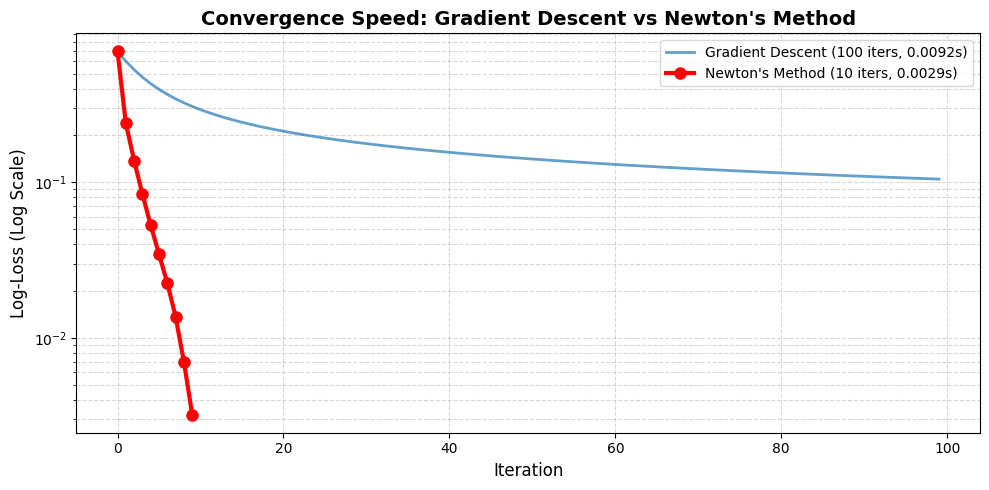


Notice how Newton's red curve drops like a rock? That's second-order optimization at work!


In [7]:
import time

def gradient_descent(X, y, lr=0.1, n_iters=100):
    """
    Standard gradient descent for logistic regression.
    Takes small steps proportional to the gradient (first-order info only).
    """
    n, d = X.shape
    theta = np.zeros(d)
    loss_history = []
    
    for _ in range(n_iters):
        h = 1 / (1 + np.exp(-X @ theta))
        loss = -np.mean(y * np.log(h + 1e-15) + (1-y) * np.log(1-h + 1e-15))
        loss_history.append(loss)
        grad = X.T @ (h - y) / n
        theta -= lr * grad  # Simple update: theta -= learning_rate * gradient
    
    return theta, loss_history

# Race time! Let's see which optimizer is faster
print("\n" + "="*60)
print("GRADIENT DESCENT vs NEWTON'S METHOD - SPEED COMPARISON")
print("="*60)

# Run Gradient Descent (100 iterations)
start_gd = time.time()
theta_gd, losses_gd = gradient_descent(X_b, y, lr=0.5, n_iters=100)
time_gd = time.time() - start_gd

print(f"\nGradient Descent: 100 iterations took {time_gd:.4f}s")

# Run Newton's Method (10 iterations max)
start_newton = time.time()
theta_newton, losses_newton = newton_logistic(X_b, y, max_iter=10)
time_newton = time.time() - start_newton

print(f"Newton's Method: {len(losses_newton)} iterations took {time_newton:.4f}s")
print(f"\nSpeedup: Newton converged {len(losses_gd)/len(losses_newton):.1f}x faster in terms of iterations!")

# Visualize the convergence curves
plt.figure(figsize=(10, 5))
plt.plot(losses_gd, label=f'Gradient Descent ({len(losses_gd)} iters, {time_gd:.4f}s)', 
         alpha=0.7, linewidth=2)
plt.plot(losses_newton, label=f"Newton's Method ({len(losses_newton)} iters, {time_newton:.4f}s)", 
         linewidth=3, marker='o', markersize=8, color='red')
plt.yscale('log')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Log-Loss (Log Scale)', fontsize=12)
plt.title('Convergence Speed: Gradient Descent vs Newton\'s Method', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("\nNotice how Newton's red curve drops like a rock? That's second-order optimization at work!")

## PART 4: Visualizing the Loss Surface

Alright, we've seen the numbers - Newton converges way faster than gradient descent. But let's actually *see* why this happens. We're going to visualize two things:

1. **The loss surface** - the landscape that our optimizer is navigating through
2. **The Hessian eigenvalues** - these tell us how sharply curved the surface is in different directions

Here's why this matters: gradient descent only knows the slope at its current position. It's like walking in fog - you can feel which way is downhill right now, but you have no idea how steep or gentle the path ahead will be.

Newton's Method, on the other hand, computes the eigenvalues of the Hessian matrix. These eigenvalues reveal the curvature strength in every direction. If the surface curves sharply in some direction, Newton knows to take a smaller step there to avoid overshooting. If it's gently curved, Newton takes a bigger leap.

Let's visualize this.

---

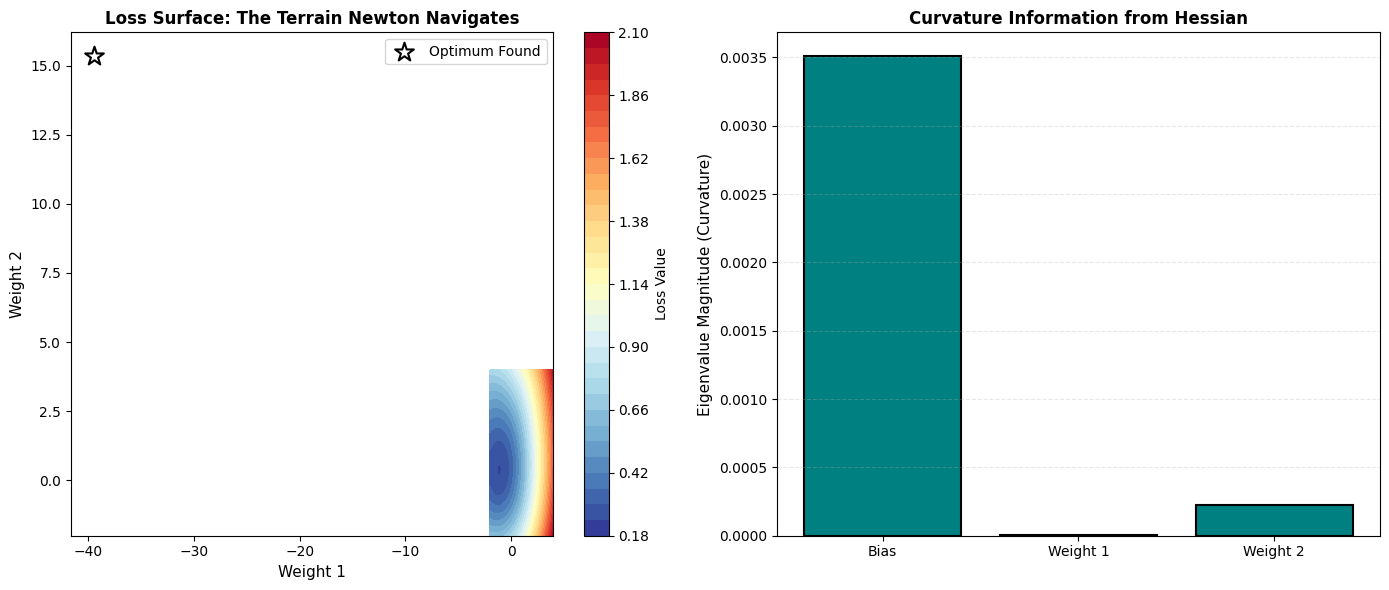


What are we seeing here?
  → LEFT: The loss surface has a clear minimum (white star) where Newton converged.
  → RIGHT: Large eigenvalues = sharp curvature in that direction.
           Newton uses this curvature info to take smarter steps!

Gradient descent only sees the slope. Newton sees the slope AND the curvature.


In [8]:
fig = plt.figure(figsize=(14, 6))

# LEFT PLOT: Loss Surface Contour
# This shows the landscape that our optimizer navigates through
ax1 = fig.add_subplot(121)
t1_range = np.linspace(-2, 4, 100)
t2_range = np.linspace(-2, 4, 100)
T1, T2 = np.meshgrid(t1_range, t2_range)

# Compute loss at every point in the grid (fixing bias term)
losses = np.zeros_like(T1)
for i in range(T1.shape[0]):
    for j in range(T1.shape[1]):
        theta_t = np.array([1.5, T1[i,j], T2[i,j]])  # Bias held constant at 1.5
        z = X_b @ theta_t
        h = 1 / (1 + np.exp(-z))
        losses[i,j] = -np.mean(y * np.log(h+1e-15) + (1-y)*np.log(1-h+1e-15))

# Plot the loss surface as a heatmap with contours
contour = ax1.contourf(T1, T2, losses, 30, cmap='RdYlBu_r')
ax1.scatter(theta_opt[1], theta_opt[2], color='white', marker='*', s=200, 
            label='Optimum Found', edgecolors='black', linewidths=1.5)
ax1.set_xlabel('Weight 1', fontsize=11)
ax1.set_ylabel('Weight 2', fontsize=11)
ax1.set_title('Loss Surface: The Terrain Newton Navigates', fontsize=12, fontweight='bold')
plt.colorbar(contour, ax=ax1, label='Loss Value')
ax1.legend()

# RIGHT PLOT: Hessian Eigenvalues
# These reveal how sharply curved the loss surface is in each direction
ax2 = fig.add_subplot(122)
z = X_b @ theta_opt
h = 1 / (1 + np.exp(-z))
S = np.diag(h * (1 - h))  # Variance weights for each training example
H = (X_b.T @ S @ X_b) / n_samples  # Compute Hessian at optimum
eigenvals = np.abs(np.linalg.eigvals(H))

# Visualize curvature strength for each parameter
ax2.bar(['Bias', 'Weight 1', 'Weight 2'], eigenvals, color='teal', edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Eigenvalue Magnitude (Curvature)', fontsize=11)
ax2.set_title('Curvature Information from Hessian', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\nWhat are we seeing here?")
print("  → LEFT: The loss surface has a clear minimum (white star) where Newton converged.")
print("  → RIGHT: Large eigenvalues = sharp curvature in that direction.")
print("           Newton uses this curvature info to take smarter steps!")
print("\nGradient descent only sees the slope. Newton sees the slope AND the curvature.")

## PART 5: Beyond Basic Newton (For the Curious)

Alright, we've covered the core Newton's Method. But here's the thing - researchers have been improving on Newton for decades. Let's look at some clever variations that solve Newton's biggest weakness: that brutal $O(n^3)$ computational cost.

### 5.1 Quasi-Newton Methods (BFGS / L-BFGS)

Here's the problem: computing and inverting the full Hessian matrix costs $O(n^3)$ time. When you have thousands of features, that's just not practical.

The breakthrough? **Quasi-Newton methods** don't compute the exact Hessian at all. Instead, they build up an approximation of it incrementally over multiple iterations, using only gradient information. It's like reconstructing the shape of a mountain by walking around and measuring slopes, rather than surveying every inch.

**The two big players:**

- **BFGS (Broyden-Fletcher-Goldfarb-Shanno):** The gold standard quasi-Newton method. Updates the Hessian approximation after each iteration to incorporate new curvature information. Most popular for medium-sized datasets (hundreds to low thousands of features).

- **L-BFGS (Limited-memory BFGS):** A memory-efficient version that only stores the last few updates instead of the full approximation matrix. This makes it practical for big data problems. You'll see this as `solver='lbfgs'` in scikit-learn's LogisticRegression.

**The tradeoff:** Quasi-Newton methods get Newton-like superlinear convergence without the full $O(n^3)$ cost per iteration. They're slower than pure Newton per iteration, but way cheaper computationally.

### 5.2 Newton with Line Search

Here's another issue: pure Newton's Method assumes the loss function is perfectly quadratic near your current position. But what if it's not? Newton might jump way too far and overshoot the minimum.

**The fix: Line Search.** After computing the Newton direction $H^{-1} \nabla J(\theta)$, we don't just blindly take the full step. Instead, we search along that direction to find the optimal step size $\alpha$:

$$\theta := \theta - \alpha H^{-1} \nabla J(\theta)$$

**Backtracking line search** is the most common approach: start with $\alpha = 1$ (full Newton step), and if that overshoots, keep halving $\alpha$ until we find a step that reduces the loss sufficiently. This guarantees we always make progress.

This hybrid approach combines Newton's smart direction with gradient descent's careful step sizing.

### 5.3 Convergence Rate Comparison

Let's put all these methods side by side and see how they stack up:

| Method | Convergence Rate | Cost per Iteration | Best For |
| :--- | :--- | :--- | :--- |
| **Newton's Method** | Quadratic (super fast!) | High ($O(n^3)$) | Small/Medium Datasets |
| **Quasi-Newton (BFGS)** | Superlinear | Medium ($O(n^2)$) | Medium Datasets |
| **Gradient Descent** | Linear | Low ($O(n)$) | Deep Learning, Big Data |

**What these convergence rates mean in practice:**
- **Quadratic convergence:** The number of correct digits doubles each iteration. Go from 0.1 error to 0.01 to 0.0001 - insanely fast!
- **Superlinear convergence:** Faster than linear, but not quite quadratic. Still excellent for most problems.
- **Linear convergence:** Error decreases by a constant factor each iteration. Reliable but requires many iterations.

**Bottom line:** Newton dominates for small problems, quasi-Newton is the sweet spot for medium problems, and gradient descent rules for massive-scale optimization.

---

## PART 6: When Newton Fails (The Gotchas)

Alright, time for some real talk. Newton's Method is powerful, but it's not perfect. Every optimization algorithm has its failure modes, and Newton is no exception. Let's look at the three critical situations where Newton breaks down - and how to fix them.

### Failure Mode 1: Ill-Conditioned Hessian (Singularity)

**The problem:** If the Hessian matrix $H$ can't be inverted (determinant $\approx 0$), the entire update rule $\theta := \theta - H^{-1}\nabla J$ completely breaks down. Your algorithm crashes.

**Why this happens:** The Hessian becomes singular when the loss surface is flat in some direction - imagine a perfect plateau where the second derivative is zero. Or when you have nearly duplicate features, making the matrix columns linearly dependent.

**The fix:** Add a tiny bit of regularization (called "damping") to the Hessian before inverting it:

```python
H = (X.T @ S @ X) / n + 1e-8 * np.eye(d)
```

That `1e-8 * np.eye(d)` adds a tiny positive value to the diagonal, ensuring the matrix can always be inverted. It's like adding a microscopic amount of curvature everywhere to prevent flat spots. This is called the **Levenberg-Marquardt damping** trick.

### Failure Mode 2: Non-Convex Surfaces (Saddle Points)

**The problem:** Newton's Method searches for points where the gradient is zero. But $\nabla J = 0$ doesn't guarantee a minimum - it could be a maximum or a saddle point! In non-convex functions with lots of bumps and valleys, Newton can converge to the wrong type of critical point.

**Why this happens:** Newton only uses local curvature information. It can't distinguish between "the gradient is zero because we're at a minimum" vs. "the gradient is zero because we're at a saddle point." Think of a mountain pass - the gradient is zero, but you're not at the top or bottom.

**The fix:** This is trickier. Options include:
- Use **multiple random initializations** and pick the solution with the lowest loss
- Check the eigenvalues of the Hessian at convergence - at a true minimum, all eigenvalues should be positive (the surface curves upward in all directions)
- Use **trust region methods** that add safeguards against jumping into bad regions

For logistic regression specifically, we're lucky - the loss function is convex, so this isn't an issue. But for neural networks or other non-convex problems, this is a real concern.

### Failure Mode 3: Computational Cost (Curse of Dimensionality)

**The problem:** For large feature spaces (say, 100,000 features), computing a $100k \times 100k$ Hessian requires massive memory ($O(n^2)$) and inverting it costs $O(n^3)$ time. With a million features? Forget about it - you'd need terabytes of RAM and hours per iteration.

**Why this happens:** The Hessian is a dense $n \times n$ matrix. Even storing it becomes prohibitive. And matrix inversion scales cubically - doubling the number of features increases the cost by 8x.

**The fix:** Switch to a different algorithm:
- **Quasi-Newton (L-BFGS):** Only stores the last few gradient updates instead of the full Hessian. Practical for thousands of features.
- **Gradient Descent:** Only costs $O(n)$ per iteration. The standard choice for deep learning with millions of parameters.
- **Stochastic variants:** Mini-batch gradient descent or stochastic Newton methods that work on subsets of data.

**Bottom line:** Newton's Method is a precision tool for small-to-medium problems. For massive-scale optimization, gradient-based methods are the only practical choice.

---

## PART 7: Your Turn - Capstone Challenge

Alright, you've made it through the theory, seen the code, and watched Newton's Method demolish gradient descent in terms of iteration count. Now it's time to put your skills to the test.

### The Challenge

Implement **Newton's Method with L2 Regularization** for a real dataset and compare its convergence against vanilla Gradient Descent. This will give you hands-on experience with the speed/cost tradeoff we've been discussing.

**Your mission:**
1. Load a real classification dataset (Titanic, breast cancer, or any binary classification problem)
2. Implement Newton's Method with L2 regularization: modify the Hessian to include the penalty term $H + \lambda I$
3. Implement gradient descent with the same L2 penalty for fair comparison
4. Track convergence metrics: loss per iteration, gradient norm, and wall-clock time
5. Visualize the convergence curves side by side

**What you'll learn:**
- How regularization affects the Hessian (it makes it better-conditioned!)
- Whether Newton's speed advantage holds on real, messy data
- The practical tradeoffs: Newton converges in fewer iterations, but each iteration costs more
- How to debug convergence issues when they arise

**Hints to get you started:**
- With L2 regularization, the gradient becomes: $\nabla J = X^T(h - y)/n + \lambda \theta$
- The Hessian becomes: $H = X^T S X / n + \lambda I$ (notice the regularization naturally adds damping!)
- Start with small $\lambda$ values like 0.01 or 0.001
- Print intermediate losses to catch any numerical issues early

**Expected outcome:** You should see Newton converge in 5-10 iterations while gradient descent needs 50-100+. But Newton's iterations will be slower. Which one wins overall? That depends on your dataset size and feature count.

This is where theory meets practice. Go build it, experiment, break things, and see what happens. That's how you really learn optimization.

---

**Good luck! And remember:** if Newton's Method isn't converging, check for singular Hessians, add more damping, or verify your gradient/Hessian computations. Debugging optimization algorithms is a skill in itself.